## COPOD: Copula-based Outlier Detection
COPOD is an interpretable, fast, and parameter-free unsupervised anomaly detection technique
Copulas are multi-variate cumulative distribution functions that describe the dependence structure between random variables.

The original COPOD paper can found [here](https://arxiv.org/abs/2009.09463)

I demonstrate the outstanding capabilities of COPOD in this notebook

### Import Relevant Libraries

In [39]:
# Import relevant models
import os
import csv

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
#from pretty_confusion_matrix import pp_matrix_from_data
import matplotlib.pyplot as plt
import seaborn as sns
from pyod.utils.data import generate_data
from sklearn.decomposition import PCA
from pyod.models.copod import COPOD
from pyod.utils.utility import precision_n_scores

from utils import save_plot, save_data
from copod import CopodModel

#sns.set(style='whitegrid')

### Generate Anomaly Detection Dataset
Randomly generate anomaly detection dataset consisting of normal and anomalous data points

In [40]:
# generate synthetic dataset
X_train, y_train, X_test, y_test = generate_data(
                                                n_train=400,
                                                n_test=100,
                                                n_features=5,
                                                contamination=0.1,
                                                random_state=1)

X_train = X_train * np.random.uniform(0, 1, size=X_train.shape)
X_test = X_test * np.random.uniform(0, 1, size=X_test.shape)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyod/utils/data.py:186: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.9.0. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  warn('behaviour="old" is deprecated and will be removed '


In [5]:
# Declare PCA for fitting the train and test dataset to obtain
# the first two principal components
pca = PCA(n_components=2)

# Train dataseat - first two principal components
train_data = pca.fit_transform(X_train)
train_data = pd.DataFrame(train_data, columns=['PC1', 'PC2'])
train_data.head()

,PC1,PC2
0,0.183590,-2.155888
1,-1.964941,-2.792179
2,-1.699108,2.885932
3,2.008053,-1.432705
4,-0.592510,0.595398


In [10]:
# Test dataseat - first two principal components
test_data = pca.transform(X_test)
test_data = pd.DataFrame(test_data, columns=['PC1', 'PC2'])
test_data.head()

,PC1,PC2
0,0.644621,0.771218
1,1.554338,-1.098014
2,-0.619852,-2.043724
3,0.126901,-0.329844
4,-1.153194,-1.878125


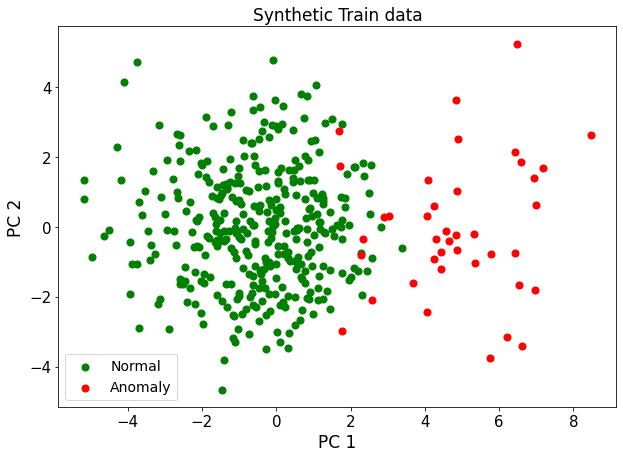

In [46]:
# Make a plot of the training dataset
cdict = {0: 'green', 1: 'red'}
label = {0: 'Normal', 1: 'Anomaly'}

fig, ax = plt.subplots(figsize=(10, 7))
for g in np.unique(y_train):
    ix = np.where(y_train == g)
    ax.scatter(train_data['PC1'].values[ix], train_data['PC2'].values[ix],
               c=cdict[g], label=label[g], s=50)
    
plt.xlabel('PC 1', fontsize=17)
plt.ylabel('PC 2', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Synthetic Train data', fontsize=17)
plt.legend(fontsize=14)
#save_plot('synthetic_train_data')
plt.show()

Saving figure... synthetic_test_data
figure can be found in:  plots


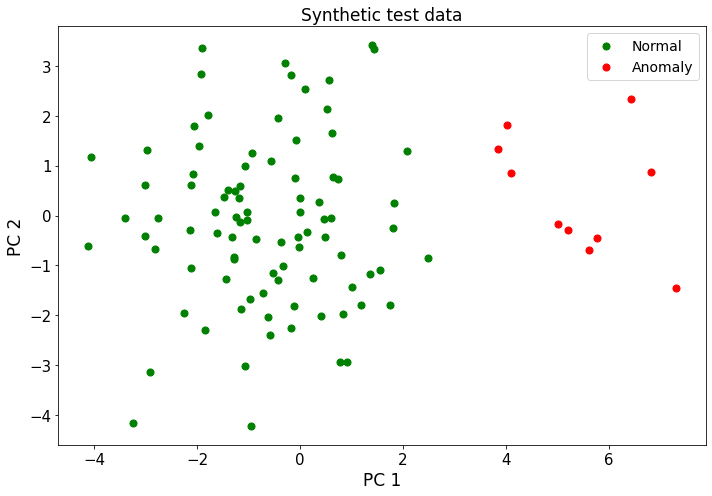

In [11]:
# Plot the synthetic test data

fig, ax = plt.subplots(figsize=(10, 7))

for g in np.unique(y_test):
    ix = np.where(y_test == g)
    ax.scatter(test_data['PC1'].values[ix], test_data['PC2'].values[ix],
               c=cdict[g], label=label[g], s=50)
    
plt.xlabel('PC 1', fontsize=17)
plt.ylabel('PC 2', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Synthetic test data', fontsize=17)
plt.legend(fontsize=14)
save_plot('synthetic_test_data')

plt.show()

## Training and Testing 

In [12]:
# Train the copod model
model = COPOD()
model.fit(X_train)

COPOD(contamination=0.1, n_jobs=1)

In [13]:
# get train decision scores and labels
train_scores = model.decision_scores_
train_labels = model.labels_

# get test decision scores and labels
test_scores = model.decision_function(X_test)
test_labels = model.predict(X_test)

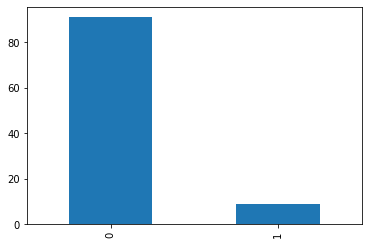

In [14]:
pd.Series(test_labels).value_counts().plot.bar()
plt.show()

## Evaluation

In [15]:
roc = np.round(roc_auc_score(y_test, test_scores), 3)
precision = np.round(precision_n_scores(y_test, test_scores), 3)

print('COPOD -> ROC: {}, PRECISION at rank n: {}'.format(roc, precision))

COPOD -> ROC: 0.996, PRECISION at rank n: 0.8


In [16]:
print('classification report on systhetic test data\n')
print(classification_report(y_test, test_labels))

classification report on systhetic test data

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98        90
         1.0       0.89      0.80      0.84        10

    accuracy                           0.97       100
   macro avg       0.93      0.89      0.91       100
weighted avg       0.97      0.97      0.97       100



# Analysis of Synthetic data with no labels

In [25]:
# combine the training and test datasets
X_combined = np.concatenate([X_train, X_test], axis=0)
y_combined = np.concatenate([y_train, y_test], axis=0)

In [26]:
# Obtain the first 2 principal components
pca2 = PCA(n_components=2)
X_combined_vis = pca2.fit_transform(X_combined)

Saving figure... combined_synthetic_data
figure can be found in:  plots


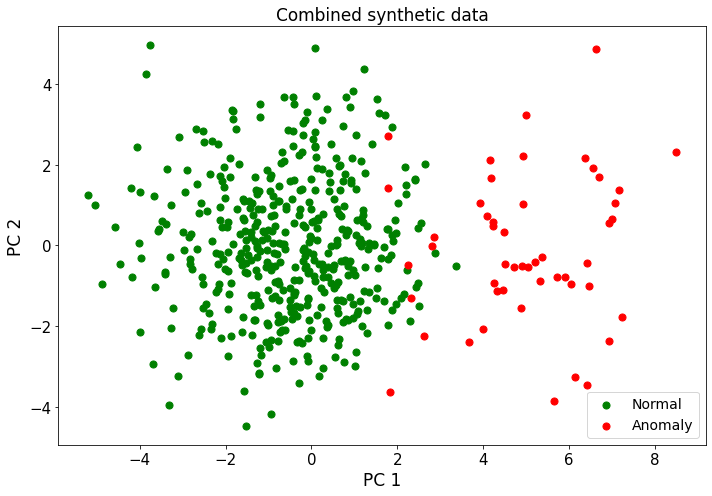

In [27]:
# Visualize the combined dataset 

fig, ax = plt.subplots(figsize=(10, 7))

for g in np.unique(y_combined):
    ix = np.where(y_combined == g)
    ax.scatter(X_combined_vis[:, 0][ix], X_combined_vis[:, 1][ix],
               c=cdict[g], label=label[g], s=50)
    
plt.xlabel('PC 1', fontsize=17)
plt.ylabel('PC 2', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Combined synthetic data', fontsize=17)
plt.legend(fontsize=14)
save_plot('combined_synthetic_data')

plt.show()

### Train copod model on combined dataset

In [28]:
model2 = COPOD()
combined_scores = model2.decision_function(X_combined)

### Visualize prediction performance

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Saving figure... unfitted_copod_detector
figure can be found in:  plots


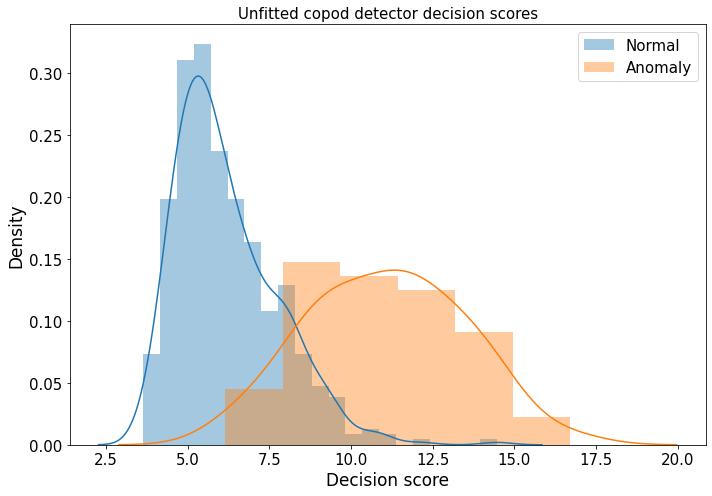

In [29]:
# make a density plot of the predicitions
plt.figure(figsize=(10, 7))
sns.distplot(combined_scores[y_combined == 0],
             label='Normal')
sns.distplot(combined_scores[y_combined == 1],
             label='Anomaly')

plt.xlabel('Decision score', fontsize=17)
plt.ylabel('Density', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Unfitted copod detector decision scores', fontsize=15)
plt.legend(fontsize=15)
save_plot('unfitted_copod_detector')

plt.show()

## Model Interpretability and Explainability

In [41]:
train_anomalies_idx = np.where(y_train==1)[0]
train_anomalies_idx

array([360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372,
       373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385,
       386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398,
       399])

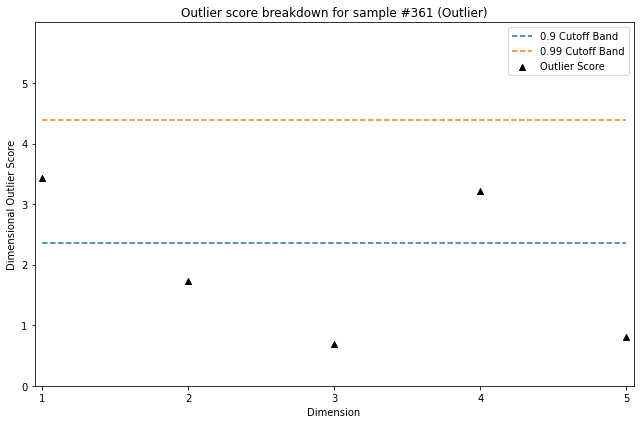

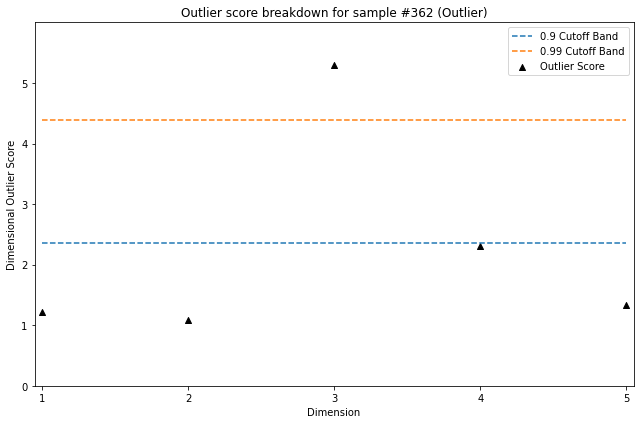

In [43]:
clf3 = COPOD()
clf3.fit(X_train)

for idx in train_anomalies_idx[:2]:
    plt.figure(figsize=(9, 6))
    clf3.explain_outlier(idx, cutoffs=None, feature_names=None,)
    